In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from glob import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### [작업1] 데이터 처리할 폴더할당

In [9]:
data_dir='./data/flower_photos/'
dataListAll=glob(data_dir + '/*')
dataListAll

['./data/flower_photos\\daisy',
 './data/flower_photos\\dandelion',
 './data/flower_photos\\LICENSE.txt',
 './data/flower_photos\\roses',
 './data/flower_photos\\sunflowers',
 './data/flower_photos\\tulips']

./data/flower_photos\roses


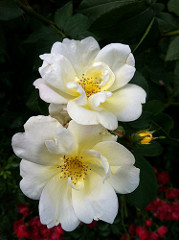

In [15]:
print(dataListAll[3])
roses = glob(dataListAll[3] + '/*.jpg')
PIL.Image.open(str(roses[0]))

#### [미션] 각 폴더단위로 jpg 데이터가 몇개씩 있는지 출력하고 각 폴더별 6개씩만 이미지 파일 출력해보기
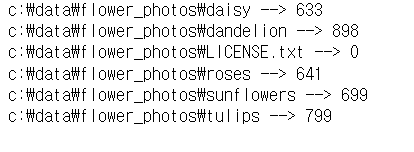

In [11]:
### 폴더단위로 jpg 몇개씩 있는지 확인해보기
for x in dataListAll:
    print(x, '-->', len(glob(x+'/*.jpg')))

dataList =[x for x in dataListAll if os.path.isdir(x)]
dataList

./data/flower_photos\daisy --> 633
./data/flower_photos\dandelion --> 898
./data/flower_photos\LICENSE.txt --> 0
./data/flower_photos\roses --> 641
./data/flower_photos\sunflowers --> 699
./data/flower_photos\tulips --> 799


daisy


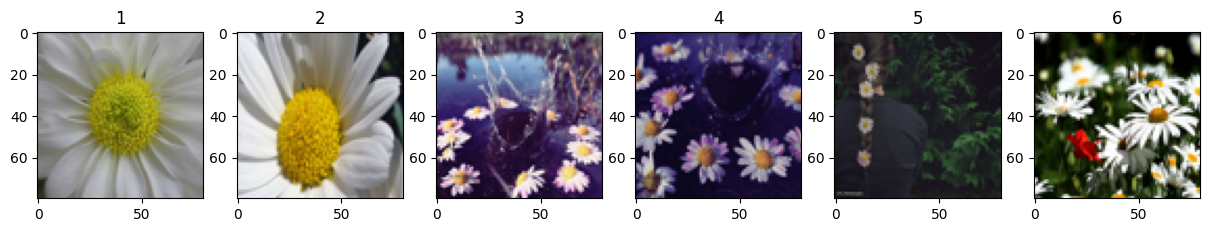

dandelion


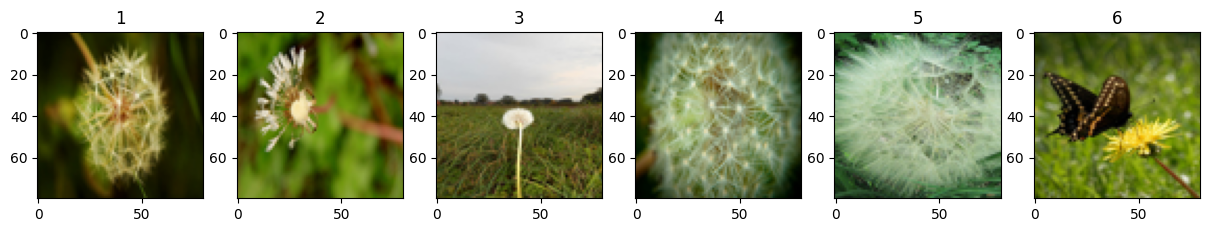

roses


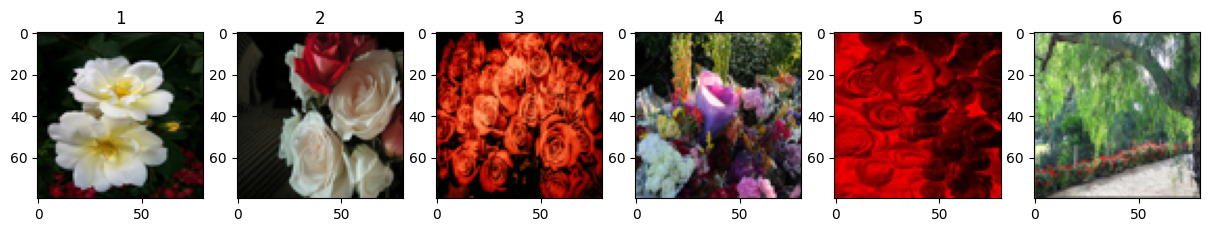

sunflowers


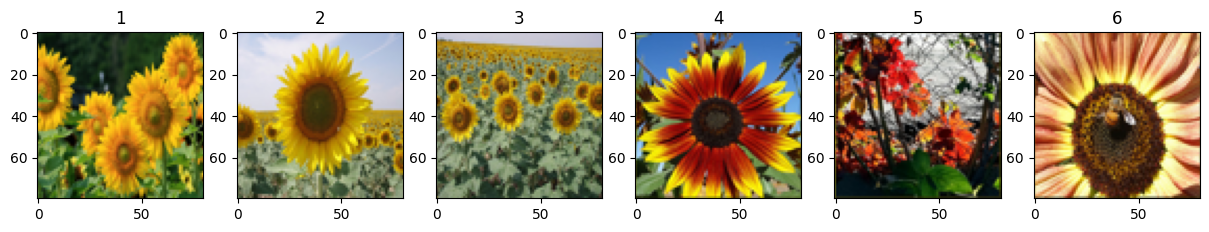

tulips


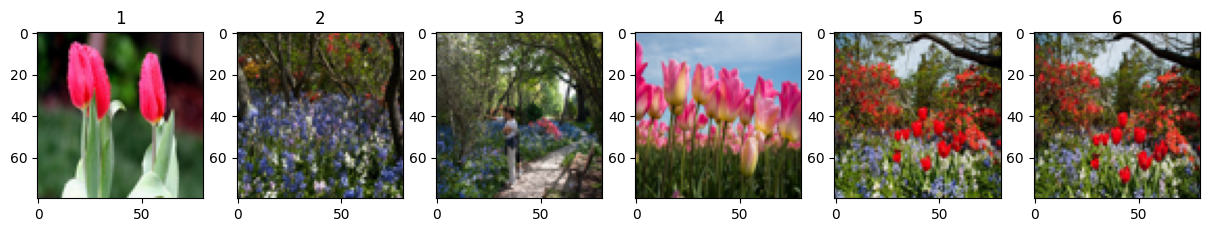

In [77]:
### 각 폴더단위로 한줄에 6개씩 이미지 출력해보기
from ctypes import resize
from PIL import Image
tmp = glob('./data/flower_photos/*')
input = int(input('이미지 갯수를 입력하세요: '))
for i in tmp:
    if i[-4:]=='.txt':
        pass
    else:
        print(i.split('\\')[1])
        imgs = glob(i+'/*.jpg')
        plt.figure(figsize=(15,3))

        for cnt,img in enumerate(imgs[:input]):
            image = Image.open(img).resize((80,80))            
            plt.subplot(1,input,cnt+1)
            plt.imshow(image)
            plt.title(cnt+1)

        plt.show()


### [작업2] keras.preprocessing을 사용하여 로드하기
- 폴더에서 지정한 배치사이즈만큼 데이터를 읽고, 이미지의 너비높이의 크기를 조정함
- 풀더에서 읽은자료를 train_ds 와 val_ds로 나누어서 보관(배치사이즈 32개씩 한세트로)
    - 이때 train_ds 와 val_ds에는 x(이미지),,y(레이블)이 같이 있음
    - train_ds[0] 은 32개의 이미지와 레이블 : 누적개수 32
    - train_ds[1] 은 32개의 이미지와 레이블 : 누적개수 64
    - train_ds[91] 은 32개의 이미지와 레이블 : 누적개수 2912
    - train_ds[92] 은 24개의 이미지와 레이블 : 누적개수 2936

In [84]:
tmp = glob('./data/flower_photos/*')
hap = 0
for fold in tmp:
    hap = hap + len(glob(fold+'/*.jpg'))
print(hap)

3670


In [85]:
batch_size = 32  # 한세트에 자료를 몇개 넣을것인가?
img_height = 180
img_width = 180

In [86]:
# 전체 3670개의 이미지자료에서 80%의 2936개를 트레이닝(훈련)자료 세팅함
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 3670*80%=2936, subset이 training여서 1-0.2임
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)  # 2936개의 이미지를 32개씩 세트해서 묶음, 즉 92개 세트가 나옴(92새트*32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [87]:
# 전체 3670개의 이미지자료에서 20%의 734개를 테스트데이터로 세팅함
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [88]:
# train_ds 에 할당된 폴더명을 가져오기
class_names = train_ds.class_names  
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### [작업3] keras.preprocessing로드 데이터 살펴보기

In [89]:
len(list(train_ds))

92

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 2, 3, 3, 1, 2, 4, 4, 4, 4, 1, 4, 3, 1, 2, 1, 0, 3, 3, 0, 4, 3,
       3, 1, 4, 1, 4, 4, 1, 1, 1, 1])>

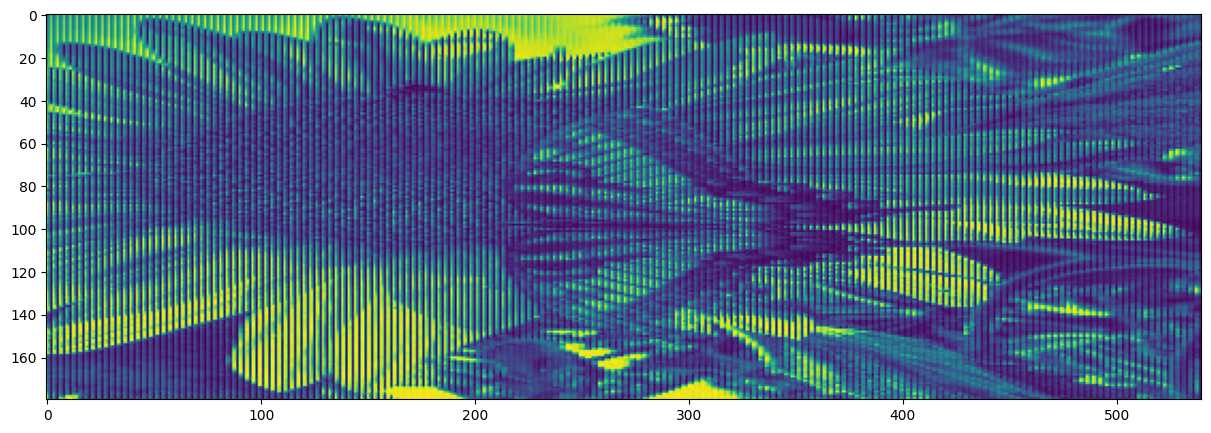

In [90]:
sample=list(train_ds)[0][0]
#sample=sample.astype('uint8')

plt.figure(figsize=(30,5))
plt.imshow(np.hstack(sample[0]))
list(train_ds)[0][1]

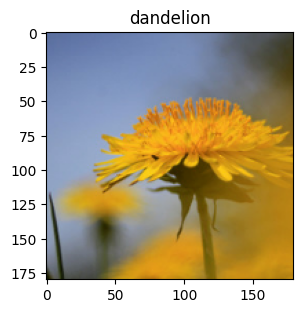

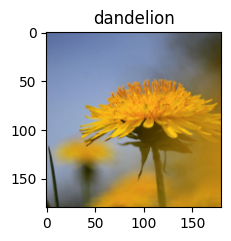

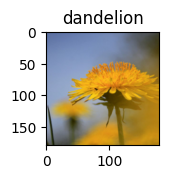

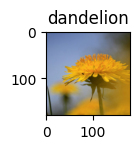

In [103]:
# 32개씩 모은 자료임
from tkinter import Y


ximg=list(train_ds)[0][0]
yLabel=list(train_ds)[0][1]

ximg=np.array(ximg, dtype='uint8')

# plt.figure(figsize=(30,5))
# plt.imshow(np.hstack(ximg))

# plt.show()
# print(np.shape(ximg), np.shape(yLabel), yLabel, class_names)

# for x in yLabel:
#     print(class_names[x])
cnt = 0
for row in range(1,5):
    plt.figure(figsize=(30,5))
    for col in range(1,9):
        plt.subplot(row,8,cnt+1)
        plt.imshow(ximg[cnt])
        plt.title(class_names[yLabel[cnt]])
plt.show()

### [작업4] 모델 제작하기

In [104]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [106]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 52s 560ms/step - loss: 1.7806 - accuracy: 0.2446 - val_loss: 1.6094 - val_accuracy: 0.2398
Epoch 2/10
92/92 [==============================] - 49s 529ms/step - loss: 1.6094 - accuracy: 0.2459 - val_loss: 1.6094 - val_accuracy: 0.2398
Epoch 3/10
92/92 [==============================] - 51s 554ms/step - loss: 1.6094 - accuracy: 0.2459 - val_loss: 1.6094 - val_accuracy: 0.2398
Epoch 4/10
92/92 [==============================] - 52s 558ms/step - loss: 1.6094 - accuracy: 0.2459 - val_loss: 1.6094 - val_accuracy: 0.2398
Epoch 5/10
92/92 [==============================] - 62s 672ms/step - loss: 1.6094 - accuracy: 0.2459 - val_loss: 1.6094 - val_accuracy: 0.2398
Epoch 6/10
92/92 [==============================] - 61s 662ms/step - loss: 1.6094 - accuracy: 0.2459 - val_loss: 1.6094 - val_accuracy: 0.2398
Epoch 7/10
92/92 [==============================] - 73s 793ms/step - loss: 1.6094 - accuracy: 0.2459 - val_loss: 1.6094 - val_accuracy: 0.2398